In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm
import random
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
import math
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_token('<PAD>')
        self.add_token('<SOS>')
        self.add_token('<EOS>')
        self.add_token('<UNK>')

    def add_token(self, token):
        if token not in self.word2idx:
            self.word2idx[token] = self.idx
            self.idx2word[self.idx] = token
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

def build_vocabulary(captions, threshold=5):
    counter = Counter()

    for caption_list in captions.values():
        for caption in caption_list:
            words = caption.lower().split()
            counter.update(words)

    vocab = Vocabulary()

    for word, count in counter.items():
        if count >= threshold:
            vocab.add_token(word)

    return vocab

def preprocess_captions(file_path, vocab_threshold=5):
    print("Loading and preprocessing captions...")

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    captions_dict = defaultdict(list)

    for line in lines:
        line = line.strip()
        if not line or ',' not in line or line.startswith("image,caption"):
            continue

        img_id, caption = line.split(',', 1)
        caption = caption.lower().strip()
        caption = ' '.join(caption.split())
        captions_dict[img_id].append(caption)

    print(f"Loaded {len(captions_dict)} images with captions")

    vocab = build_vocabulary(captions_dict, vocab_threshold)
    print(f"Vocabulary size: {len(vocab)}")

    return captions_dict, vocab

def extract_image_features(image_dir, captions_dict, save_path="image_features.pkl"):
    print("Extracting image features...")

    resnet = models.resnet50(pretrained=True)
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    feature_extractor.eval()
    feature_extractor.to(device)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    image_features = {}

    with torch.no_grad():
        for img_file in tqdm(captions_dict.keys(), desc="Extracting features"):
            img_path = os.path.join(image_dir, img_file)

            if os.path.exists(img_path):
                try:
                    image = Image.open(img_path).convert('RGB')
                    image_tensor = transform(image).unsqueeze(0).to(device)

                    features = feature_extractor(image_tensor)
                    features = features.squeeze().cpu().numpy()

                    image_features[img_file] = features

                except Exception as e:
                    print(f"Error processing {img_file}: {e}")
                    continue

    with open(save_path, 'wb') as f:
        pickle.dump(image_features, f)

    print(f"Extracted features for {len(image_features)} images")
    return image_features


In [5]:
class CaptionDataset(Dataset):
    def __init__(self, image_features, captions_dict, vocab, max_length=20):
        self.image_features = image_features
        self.captions_dict = captions_dict
        self.vocab = vocab
        self.max_length = max_length

        self.pairs = self._create_pairs()

    def _create_pairs(self):
        pairs = []

        for img_id, features in self.image_features.items():
            if img_id not in self.captions_dict:
                continue

            for caption in self.captions_dict[img_id]:
                words = caption.split()

                if len(words) > self.max_length - 2:
                    words = words[:self.max_length - 2]

                caption_indices = [self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>'])
                                 for word in words]

                caption_indices = [self.vocab.word2idx['<SOS>']] + caption_indices + [self.vocab.word2idx['<EOS>']]

                pairs.append((features, caption_indices, len(caption_indices)))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        features, caption, length = self.pairs[idx]
        return torch.FloatTensor(features), torch.LongTensor(caption), length

def collate_fn(batch):
    features, captions, lengths = zip(*batch)

    features = torch.stack(features, 0)

    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    return features, captions, lengths


In [6]:
class ImageCaptionModel(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size, num_layers=1, dropout=0.5):
        super(ImageCaptionModel, self).__init__()

        self.feature_dim = feature_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.feature_proj = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, vocab_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        batch_size = features.size(0)

        features = self.feature_proj(features)
        h_0 = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        embedded = self.embedding(captions[:, :-1])
        embedded = self.dropout(embedded)

        lstm_out, _ = self.lstm(embedded, (h_0, c_0))
        predictions = self.output_proj(lstm_out)

        return predictions

    def generate_caption(self, features, vocab, max_length=20, temperature=1.0):
        self.eval()

        with torch.no_grad():
            batch_size = features.size(0)

            features = self.feature_proj(features)

            h = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c = torch.zeros_like(h)

            input_word = torch.LongTensor([[vocab.word2idx['<SOS>']]]).to(features.device)

            generated_words = []

            for _ in range(max_length):
                embedded = self.embedding(input_word)

                lstm_out, (h, c) = self.lstm(embedded, (h, c))

                predictions = self.output_proj(lstm_out)
                predictions = predictions.squeeze(1)

                if temperature != 1.0:
                    predictions = predictions / temperature

                predicted_id = predictions.argmax(dim=1).item()

                if predicted_id in vocab.idx2word:
                    word = vocab.idx2word[predicted_id]

                    if word == '<EOS>':
                        break
                    elif word not in ['<PAD>', '<SOS>']:
                        generated_words.append(word)

                input_word = torch.LongTensor([[predicted_id]]).to(features.device)

            return ' '.join(generated_words)


In [7]:
def train_model(model, train_loader, val_loader, vocab, num_epochs=15, lr=0.001):

    criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    model.to(device)

    train_losses = []
    val_losses = []

    print("Starting training...")
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (features, captions, lengths) in enumerate(train_pbar):
            features = features.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            predictions = model(features, captions)
            targets = captions[:, 1:]

            loss = criterion(predictions.reshape(-1, predictions.size(-1)), targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for features, captions, lengths in val_pbar:
                features = features.to(device)
                captions = captions.to(device)

                predictions = model(features, captions)
                targets = captions[:, 1:]

                loss = criterion(predictions.reshape(-1, predictions.size(-1)), targets.reshape(-1))
                total_val_loss += loss.item()
                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print()

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")

    return train_losses, val_losses

In [8]:
def evaluate_bleu_scores(model, test_features, test_captions, vocab, max_length=20):
    model.eval()
    actual = []
    predicted = []

    print("Generating captions for BLEU evaluation...")

    for img_id in tqdm(list(test_captions.keys())[:1000]):  # Evaluate on subset
        if img_id not in test_features:
            continue

        references = [caption.split() for caption in test_captions[img_id]]
        actual.append(references)

        features = torch.FloatTensor(test_features[img_id]).unsqueeze(0).to(device)
        predicted_caption = model.generate_caption(features, vocab, max_length)
        predicted.append(predicted_caption.split())

    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {
        'BLEU-1': bleu_1,
        'BLEU-2': bleu_2,
        'BLEU-3': bleu_3,
        'BLEU-4': bleu_4
    }, actual, predicted

def show_sample_results(model, image_dir, image_features, captions_dict, vocab, num_samples=5):

    model.eval()
    sample_images = list(image_features.keys())[:num_samples]

    plt.figure(figsize=(15, 3*num_samples))

    for i, img_name in enumerate(sample_images):
        if img_name not in captions_dict:
            continue

        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            continue

        image = Image.open(img_path).convert('RGB')

        features = torch.FloatTensor(image_features[img_name]).unsqueeze(0).to(device)
        predicted_caption = model.generate_caption(features, vocab)

        reference_captions = captions_dict[img_name]

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image)
        plt.axis('off')

        title = f"Predicted: {predicted_caption}\n"
        title += f"Reference: {' | '.join(reference_captions[:2])}"  # Show first 2 references

        plt.title(title, fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()


STEP 1: DATA PREPROCESSING
Loading and preprocessing captions...
Loaded 8091 images with captions
Vocabulary size: 3040
Loading existing image features...

STEP 2: DATA SPLITTING
Train: 5663 images
Validation: 1214 images
Test: 1214 images

STEP 3: CREATING DATASETS
Train batches: 885
Validation batches: 190
Vocabulary size: 3040

STEP 4: MODEL INITIALIZATION
Model parameters: 4,963,808
Trainable parameters: 4,963,808

STEP 5: TRAINING
Starting training...


Epoch 1/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 199.90it/s, Loss=3.9397]


Epoch 1/35:
  Train Loss: 4.4782
  Val Loss: 3.8898
  Learning Rate: 0.000100



Epoch 2/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 196.01it/s, Loss=3.6137]


Epoch 2/35:
  Train Loss: 3.7286
  Val Loss: 3.5703
  Learning Rate: 0.000100



Epoch 3/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 201.39it/s, Loss=3.4461]


Epoch 3/35:
  Train Loss: 3.4719
  Val Loss: 3.3805
  Learning Rate: 0.000100



Epoch 4/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 208.37it/s, Loss=3.2991]


Epoch 4/35:
  Train Loss: 3.3069
  Val Loss: 3.2524
  Learning Rate: 0.000100



Epoch 5/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 200.49it/s, Loss=3.2151]


Epoch 5/35:
  Train Loss: 3.1739
  Val Loss: 3.1490
  Learning Rate: 0.000080



Epoch 6/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 206.30it/s, Loss=3.1483]


Epoch 6/35:
  Train Loss: 3.0740
  Val Loss: 3.0875
  Learning Rate: 0.000080



Epoch 7/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 194.80it/s, Loss=3.1053]


Epoch 7/35:
  Train Loss: 3.0039
  Val Loss: 3.0366
  Learning Rate: 0.000080



Epoch 8/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 209.32it/s, Loss=3.0609]


Epoch 8/35:
  Train Loss: 2.9436
  Val Loss: 2.9959
  Learning Rate: 0.000080



Epoch 9/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 203.99it/s, Loss=3.0153]


Epoch 9/35:
  Train Loss: 2.8888
  Val Loss: 2.9558
  Learning Rate: 0.000080



Epoch 10/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 206.21it/s, Loss=3.0039]


Epoch 10/35:
  Train Loss: 2.8418
  Val Loss: 2.9274
  Learning Rate: 0.000064



Epoch 11/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 203.11it/s, Loss=2.9749]


Epoch 11/35:
  Train Loss: 2.7989
  Val Loss: 2.9089
  Learning Rate: 0.000064



Epoch 12/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 203.51it/s, Loss=2.9541]


Epoch 12/35:
  Train Loss: 2.7658
  Val Loss: 2.8877
  Learning Rate: 0.000064



Epoch 13/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 204.71it/s, Loss=2.9619]


Epoch 13/35:
  Train Loss: 2.7359
  Val Loss: 2.8623
  Learning Rate: 0.000064



Epoch 14/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 207.34it/s, Loss=2.9443]


Epoch 14/35:
  Train Loss: 2.7086
  Val Loss: 2.8500
  Learning Rate: 0.000064



Epoch 15/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 210.09it/s, Loss=2.9264]


Epoch 15/35:
  Train Loss: 2.6803
  Val Loss: 2.8336
  Learning Rate: 0.000051



Epoch 16/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 209.02it/s, Loss=2.9220]


Epoch 16/35:
  Train Loss: 2.6555
  Val Loss: 2.8241
  Learning Rate: 0.000051



Epoch 17/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 204.62it/s, Loss=2.9090]


Epoch 17/35:
  Train Loss: 2.6357
  Val Loss: 2.8104
  Learning Rate: 0.000051



Epoch 18/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 209.84it/s, Loss=2.9018]


Epoch 18/35:
  Train Loss: 2.6164
  Val Loss: 2.7999
  Learning Rate: 0.000051



Epoch 19/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 208.73it/s, Loss=2.8993]


Epoch 19/35:
  Train Loss: 2.5990
  Val Loss: 2.7918
  Learning Rate: 0.000051



Epoch 20/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 208.94it/s, Loss=2.9106]


Epoch 20/35:
  Train Loss: 2.5815
  Val Loss: 2.7871
  Learning Rate: 0.000041



Epoch 21/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 202.20it/s, Loss=2.9067]


Epoch 21/35:
  Train Loss: 2.5638
  Val Loss: 2.7763
  Learning Rate: 0.000041



Epoch 22/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 208.24it/s, Loss=2.9091]


Epoch 22/35:
  Train Loss: 2.5497
  Val Loss: 2.7731
  Learning Rate: 0.000041



Epoch 23/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 207.29it/s, Loss=2.8874]


Epoch 23/35:
  Train Loss: 2.5367
  Val Loss: 2.7683
  Learning Rate: 0.000041



Epoch 24/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 207.73it/s, Loss=2.9033]


Epoch 24/35:
  Train Loss: 2.5245
  Val Loss: 2.7604
  Learning Rate: 0.000041



Epoch 25/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 209.07it/s, Loss=2.8908]


Epoch 25/35:
  Train Loss: 2.5125
  Val Loss: 2.7547
  Learning Rate: 0.000033



Epoch 26/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 201.66it/s, Loss=2.8821]


Epoch 26/35:
  Train Loss: 2.4999
  Val Loss: 2.7512
  Learning Rate: 0.000033



Epoch 27/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 200.21it/s, Loss=2.8807]


Epoch 27/35:
  Train Loss: 2.4889
  Val Loss: 2.7464
  Learning Rate: 0.000033



Epoch 28/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 207.27it/s, Loss=2.8757]


Epoch 28/35:
  Train Loss: 2.4791
  Val Loss: 2.7410
  Learning Rate: 0.000033



Epoch 29/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 209.36it/s, Loss=2.8781]


Epoch 29/35:
  Train Loss: 2.4707
  Val Loss: 2.7404
  Learning Rate: 0.000033



Epoch 30/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 208.98it/s, Loss=2.8836]


Epoch 30/35:
  Train Loss: 2.4610
  Val Loss: 2.7400
  Learning Rate: 0.000026



Epoch 31/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 198.24it/s, Loss=2.8803]


Epoch 31/35:
  Train Loss: 2.4508
  Val Loss: 2.7315
  Learning Rate: 0.000026



Epoch 32/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 196.02it/s, Loss=2.8698]


Epoch 32/35:
  Train Loss: 2.4447
  Val Loss: 2.7276
  Learning Rate: 0.000026



Epoch 33/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 204.12it/s, Loss=2.8752]


Epoch 33/35:
  Train Loss: 2.4366
  Val Loss: 2.7269
  Learning Rate: 0.000026



Epoch 34/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 202.13it/s, Loss=2.8681]


Epoch 34/35:
  Train Loss: 2.4306
  Val Loss: 2.7257
  Learning Rate: 0.000026



Epoch 35/35 [Val]: 100%|██████████| 190/190 [00:00<00:00, 206.33it/s, Loss=2.8763]


Epoch 35/35:
  Train Loss: 2.4233
  Val Loss: 2.7226
  Learning Rate: 0.000021

Training completed in 361.13 seconds

STEP 6: SAVING MODEL
Model saved as 'caption_model_pytorch.pth'
Vocabulary saved as 'vocab_pytorch.pkl'
Model config saved as 'model_config_pytorch.pkl'

STEP 7: EVALUATION
Generating captions for BLEU evaluation...


100%|██████████| 1000/1000 [00:07<00:00, 126.96it/s]


BLEU Scores:
  BLEU-1: 0.5805
  BLEU-2: 0.3783
  BLEU-3: 0.2502
  BLEU-4: 0.1600


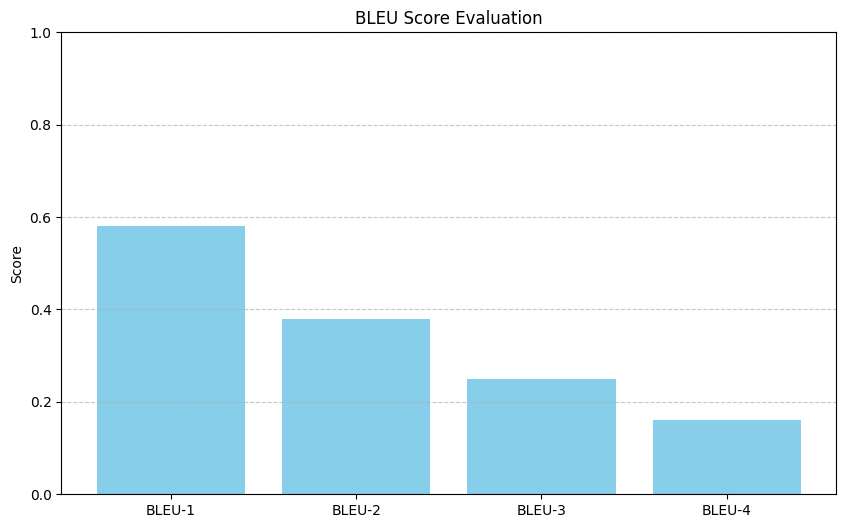


Sample Results:


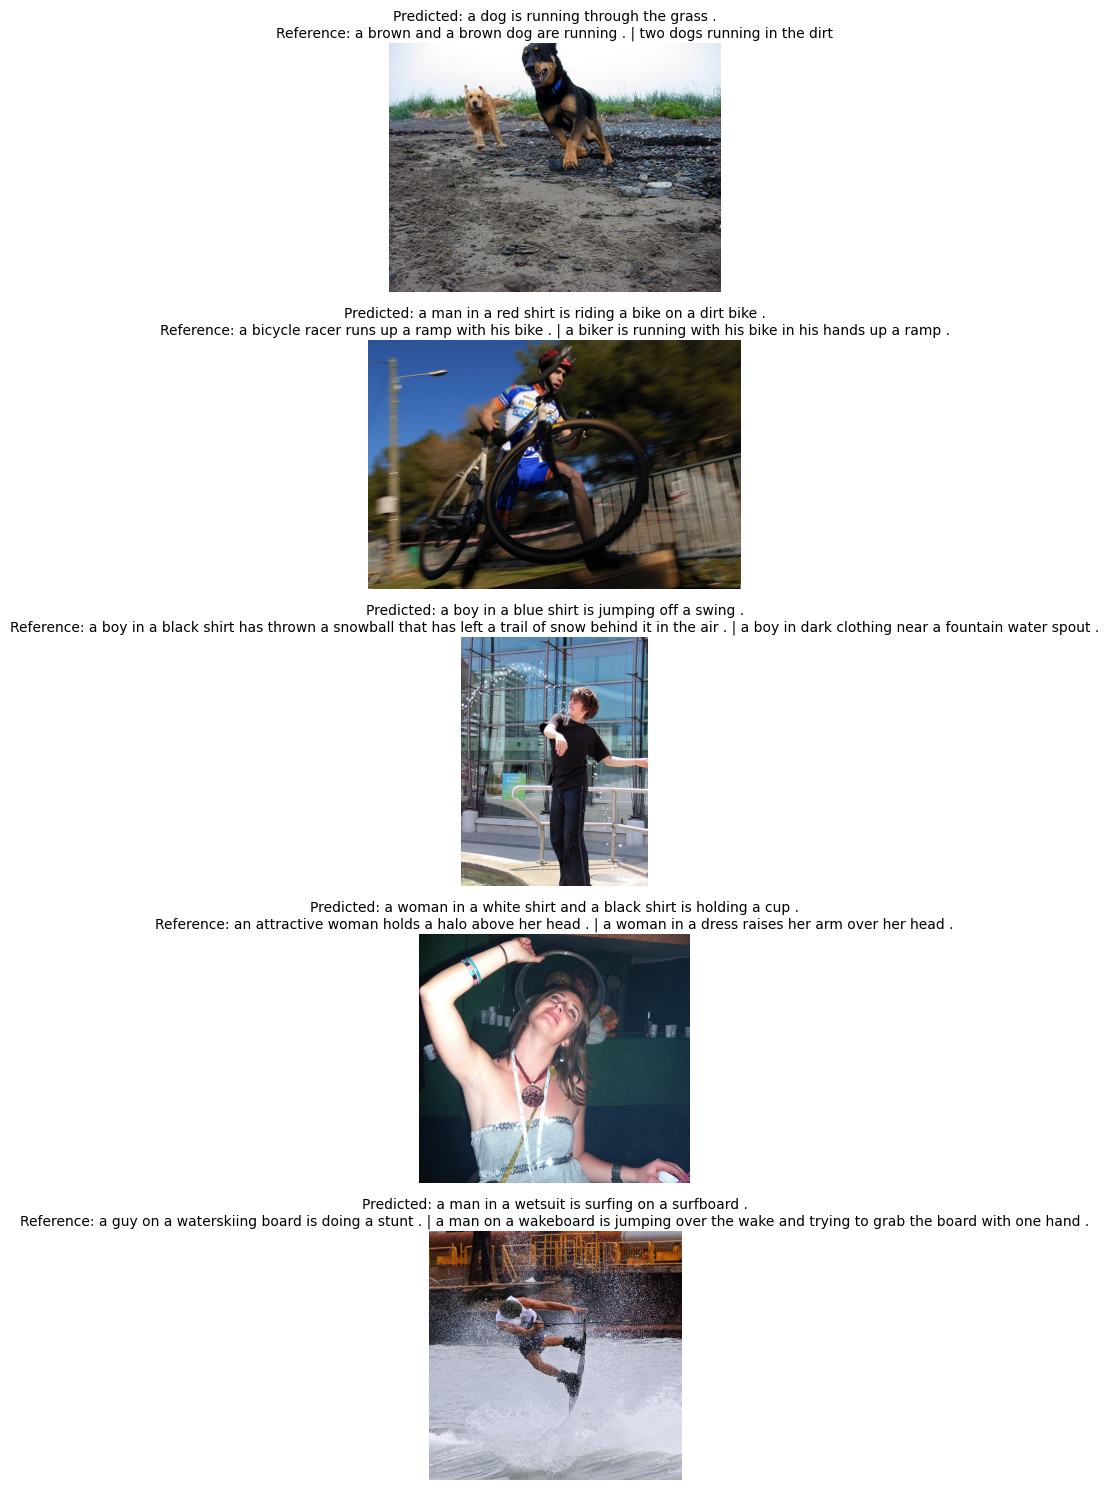

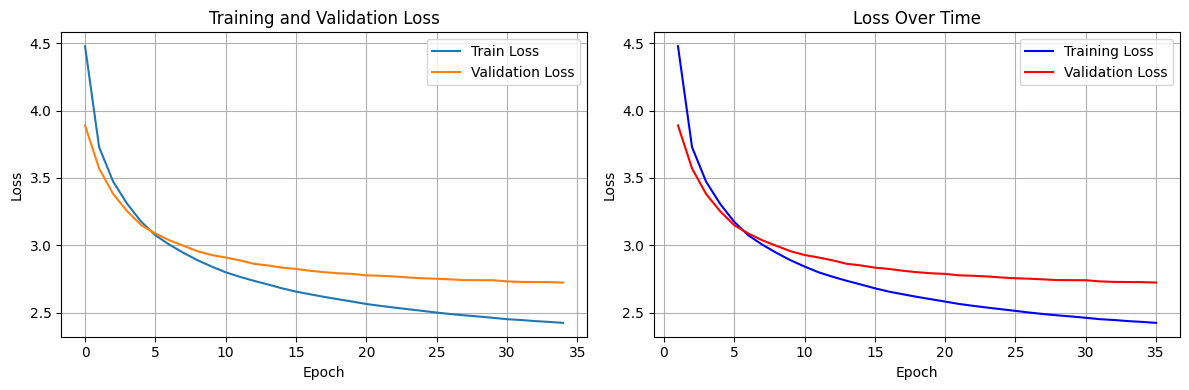


TRAINING AND EVALUATION COMPLETED!


In [9]:
def main():
    captions_path = r"C:\Users\g0d2o\OneDrive\Рабочий стол\final\captions.txt"
    image_dir = r"C:\Users\g0d2o\OneDrive\Рабочий стол\final\Images"

    print("="*50)
    print("STEP 1: DATA PREPROCESSING")
    print("="*50)

    captions_dict, vocab = preprocess_captions(captions_path, vocab_threshold=5)

    features_path = "image_features_pytorch.pkl"
    if os.path.exists(features_path):
        print("Loading existing image features...")
        with open(features_path, 'rb') as f:
            image_features = pickle.load(f)
    else:
        image_features = extract_image_features(image_dir, captions_dict, features_path)

    print("\n" + "="*50)
    print("STEP 2: DATA SPLITTING")
    print("="*50)

    all_img_ids = list(set(captions_dict.keys()) & set(image_features.keys()))

    train_ids, temp_ids = train_test_split(all_img_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

    print(f"Train: {len(train_ids)} images")
    print(f"Validation: {len(val_ids)} images")
    print(f"Test: {len(test_ids)} images")

    train_features = {img_id: image_features[img_id] for img_id in train_ids}
    val_features = {img_id: image_features[img_id] for img_id in val_ids}
    test_features = {img_id: image_features[img_id] for img_id in test_ids}

    train_captions = {img_id: captions_dict[img_id] for img_id in train_ids}
    val_captions = {img_id: captions_dict[img_id] for img_id in val_ids}
    test_captions = {img_id: captions_dict[img_id] for img_id in test_ids}

    print("\n" + "="*50)
    print("STEP 3: CREATING DATASETS")
    print("="*50)

    train_dataset = CaptionDataset(train_features, train_captions, vocab, max_length=25)
    val_dataset = CaptionDataset(val_features, val_captions, vocab, max_length=25)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Vocabulary size: {len(vocab)}")

    print("\n" + "="*50)
    print("STEP 4: MODEL INITIALIZATION")
    print("="*50)

    model = ImageCaptionModel(
        feature_dim=2048,
        embed_dim=256,
        hidden_dim=512,
        vocab_size=len(vocab),
        num_layers=1,
        dropout=0.5
    )

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    print("\n" + "="*50)
    print("STEP 5: TRAINING")
    print("="*50)

    train_losses, val_losses = train_model(
        model, train_loader, val_loader, vocab,
        num_epochs=35, lr=0.0001
    )

    print("\n" + "="*50)
    print("STEP 6: SAVING MODEL")
    print("="*50)

    torch.save(model.state_dict(), 'caption_model_pytorch.pth')

    with open('vocab_pytorch.pkl', 'wb') as f:
        pickle.dump(vocab, f)

    with open('model_config_pytorch.pkl', 'wb') as f:
        pickle.dump({
            'feature_dim': 2048,
            'embed_dim': 256,
            'hidden_dim': 512,
            'vocab_size': len(vocab),
            'num_layers': 1,
            'dropout': 0.5
        }, f)

    print("Model saved as 'caption_model_pytorch.pth'")
    print("Vocabulary saved as 'vocab_pytorch.pkl'")
    print("Model config saved as 'model_config_pytorch.pkl'")

    print("\n" + "="*50)
    print("STEP 7: EVALUATION")
    print("="*50)

    bleu_scores, actual, predicted = evaluate_bleu_scores(
        model, test_features, test_captions, vocab
    )

    print("BLEU Scores:")
    for metric, score in bleu_scores.items():
        print(f"  {metric}: {score:.4f}")

    # Visualize BLEU scores
    plt.figure(figsize=(10, 6))
    plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
    plt.title('BLEU Score Evaluation')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nSample Results:")
    show_sample_results(model, image_dir, test_features, test_captions, vocab, num_samples=5)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*50)
    print("TRAINING AND EVALUATION COMPLETED!")
    print("="*50)

if __name__ == "__main__":
    main()

Using device: cuda
ATTENTION-BASED IMAGE CAPTIONING EXPERIMENTS
Loading and preprocessing captions...
Loaded 8091 images with captions
Vocabulary size: 3040


C:\Users\g0d2o\miniconda3\envs\Object_detection_tutorial_2\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Training Transformer model...


Epoch 1/15 [Train]: 100%|██████████| 1770/1770 [01:41<00:00, 17.49it/s, Loss=2.5705]


Epoch 1: Train Loss: 3.4091, Val Loss: 2.9630


Epoch 2/15 [Train]: 100%|██████████| 1770/1770 [01:42<00:00, 17.33it/s, Loss=2.2697]


Epoch 2: Train Loss: 2.7609, Val Loss: 2.7540


Epoch 3/15 [Train]: 100%|██████████| 1770/1770 [01:41<00:00, 17.45it/s, Loss=2.3096]


Epoch 3: Train Loss: 2.5126, Val Loss: 2.6465


Epoch 4/15 [Train]: 100%|██████████| 1770/1770 [01:41<00:00, 17.43it/s, Loss=2.4728]


Epoch 4: Train Loss: 2.3379, Val Loss: 2.5982


Epoch 5/15 [Train]: 100%|██████████| 1770/1770 [01:41<00:00, 17.46it/s, Loss=2.4445]


Epoch 5: Train Loss: 2.1938, Val Loss: 2.5734


Epoch 6/15 [Train]: 100%|██████████| 1770/1770 [01:41<00:00, 17.36it/s, Loss=2.1190]


Epoch 6: Train Loss: 2.0660, Val Loss: 2.5714


Epoch 7/15 [Train]: 100%|██████████| 1770/1770 [01:40<00:00, 17.68it/s, Loss=2.2439]


Epoch 7: Train Loss: 1.9481, Val Loss: 2.5952


Epoch 8/15 [Train]: 100%|██████████| 1770/1770 [01:39<00:00, 17.70it/s, Loss=1.5091]


Epoch 8: Train Loss: 1.7946, Val Loss: 2.5987


Epoch 9/15 [Train]: 100%|██████████| 1770/1770 [01:40<00:00, 17.65it/s, Loss=1.9353]


Epoch 9: Train Loss: 1.6944, Val Loss: 2.6312


Epoch 10/15 [Train]: 100%|██████████| 1770/1770 [01:40<00:00, 17.65it/s, Loss=1.5456]


Epoch 10: Train Loss: 1.6054, Val Loss: 2.6712


Epoch 11/15 [Train]: 100%|██████████| 1770/1770 [01:40<00:00, 17.69it/s, Loss=1.7345]


Epoch 11: Train Loss: 1.5176, Val Loss: 2.7159


Epoch 12/15 [Train]: 100%|██████████| 1770/1770 [01:40<00:00, 17.61it/s, Loss=1.5293]


Epoch 12: Train Loss: 1.4361, Val Loss: 2.7558


Epoch 13/15 [Train]: 100%|██████████| 1770/1770 [01:39<00:00, 17.72it/s, Loss=1.5878]


Epoch 13: Train Loss: 1.3592, Val Loss: 2.8047


Epoch 14/15 [Train]: 100%|██████████| 1770/1770 [01:39<00:00, 17.74it/s, Loss=1.4367]


Epoch 14: Train Loss: 1.2860, Val Loss: 2.8536


Epoch 15/15 [Train]: 100%|██████████| 1770/1770 [01:40<00:00, 17.66it/s, Loss=1.2919]


Epoch 15: Train Loss: 1.1727, Val Loss: 2.9091
Training Visual Attention model...


Epoch 1/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.37it/s, Loss=3.6721]


Epoch 1: Train Loss: 4.2395, Val Loss: 3.7104


Epoch 2/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.37it/s, Loss=3.1822]


Epoch 2: Train Loss: 3.5126, Val Loss: 3.3657


Epoch 3/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.38it/s, Loss=3.2352]


Epoch 3: Train Loss: 3.2208, Val Loss: 3.1754


Epoch 4/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.34it/s, Loss=2.8741]


Epoch 4: Train Loss: 3.0284, Val Loss: 3.0451


Epoch 5/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.33it/s, Loss=2.7103]


Epoch 5: Train Loss: 2.8813, Val Loss: 2.9660


Epoch 6/15 [Train]: 100%|██████████| 1770/1770 [01:54<00:00, 15.40it/s, Loss=2.3202]


Epoch 6: Train Loss: 2.7653, Val Loss: 2.9022


Epoch 7/15 [Train]: 100%|██████████| 1770/1770 [01:53<00:00, 15.54it/s, Loss=2.7754]


Epoch 7: Train Loss: 2.6708, Val Loss: 2.8502


Epoch 8/15 [Train]: 100%|██████████| 1770/1770 [01:53<00:00, 15.60it/s, Loss=2.3668]


Epoch 8: Train Loss: 2.5818, Val Loss: 2.8191


Epoch 9/15 [Train]: 100%|██████████| 1770/1770 [01:54<00:00, 15.43it/s, Loss=2.1667]


Epoch 9: Train Loss: 2.5187, Val Loss: 2.7964


Epoch 10/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.34it/s, Loss=2.1230]


Epoch 10: Train Loss: 2.4595, Val Loss: 2.7903


Epoch 11/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.30it/s, Loss=2.3155]


Epoch 11: Train Loss: 2.4073, Val Loss: 2.7708


Epoch 12/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.38it/s, Loss=2.7806]


Epoch 12: Train Loss: 2.3566, Val Loss: 2.7644


Epoch 13/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.34it/s, Loss=2.6717]


Epoch 13: Train Loss: 2.3104, Val Loss: 2.7476


Epoch 14/15 [Train]: 100%|██████████| 1770/1770 [01:55<00:00, 15.31it/s, Loss=1.8445]


Epoch 14: Train Loss: 2.2637, Val Loss: 2.7463


Epoch 15/15 [Train]: 100%|██████████| 1770/1770 [01:54<00:00, 15.41it/s, Loss=2.3774]


Epoch 15: Train Loss: 2.2128, Val Loss: 2.7375


Generating captions with Visual Attention: 100%|██████████| 200/200 [00:02<00:00, 69.45it/s]



PERFORMANCE COMPARISON RESULTS

Transformer Model:
  BLEU-1: 0.5900
  BLEU-4: 0.1479

Visual Attention Model:
  BLEU-1: 0.6355
  BLEU-4: 0.1878


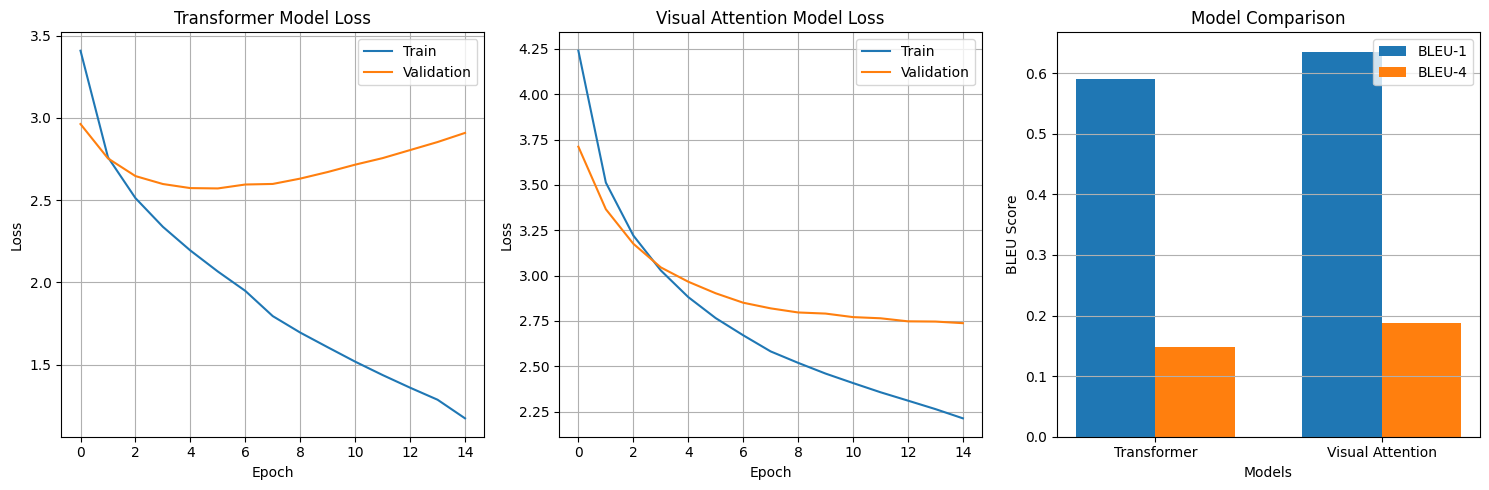

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.w_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        attn_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )

        output = self.w_o(attn_output)
        return output, attention_weights

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super().__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None):
        attn_output, self_attn_weights = self.self_attention(x, x, x, self_attn_mask)
        x = self.norm1(x + self.dropout(attn_output))

        attn_output, cross_attn_weights = self.cross_attention(x, encoder_output, encoder_output, cross_attn_mask)
        x = self.norm2(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x, self_attn_weights, cross_attn_weights

class AttentionImageCaptionModel(nn.Module):
    def __init__(self, feature_dim, d_model, num_heads, num_layers, vocab_size,
                 d_ff=2048, max_seq_length=50, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length

        self.feature_proj = nn.Sequential(
            nn.Linear(feature_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)

        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.output_proj = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_masks(self, tgt_seq):
            batch_size, seq_len = tgt_seq.size()

            causal_mask = torch.tril(torch.ones((seq_len, seq_len), device=tgt_seq.device)).bool()
            causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
            causal_mask = causal_mask.expand(batch_size, 1, seq_len, seq_len)

            pad_mask = (tgt_seq != 0).unsqueeze(1).unsqueeze(2)
            mask = causal_mask & pad_mask
            return mask

    def forward(self, image_features, captions):
        img_features = self.feature_proj(image_features).unsqueeze(1)
        tgt_seq = captions[:, :-1]

        embedded = self.embedding(tgt_seq) * math.sqrt(self.d_model)
        embedded = self.pos_encoding(embedded.transpose(0, 1)).transpose(0, 1)
        embedded = self.dropout(embedded)

        self_attn_mask = self.create_masks(tgt_seq)

        output = embedded
        attention_weights = []

        for layer in self.decoder_layers:
            output, self_attn, cross_attn = layer(
                output, img_features, self_attn_mask, None
            )
            attention_weights.append((self_attn, cross_attn))

        predictions = self.output_proj(output)
        return predictions, attention_weights

    def generate_caption(self, image_features, vocab, max_length=20, temperature=1.0):
        self.eval()

        with torch.no_grad():
            device = image_features.device
            img_features = self.feature_proj(image_features).unsqueeze(1)
            generated = torch.LongTensor([[vocab.word2idx['<SOS>']]]).to(device)

            for _ in range(max_length):
                embedded = self.embedding(generated) * math.sqrt(self.d_model)
                embedded = self.pos_encoding(embedded.transpose(0, 1)).transpose(0, 1)

                mask = self.create_masks(generated)

                output = embedded
                for layer in self.decoder_layers:
                    output, _, _ = layer(output, img_features, mask, None)

                predictions = self.output_proj(output[:, -1, :])

                if temperature != 1.0:
                    predictions = predictions / temperature

                predicted_id = predictions.argmax(dim=1).item()

                if predicted_id == vocab.word2idx['<EOS>']:
                    break

                next_token = torch.LongTensor([[predicted_id]]).to(device)
                generated = torch.cat([generated, next_token], dim=1)

            words = []
            for token_id in generated.squeeze().tolist()[1:]:
                if token_id in vocab.idx2word:
                    word = vocab.idx2word[token_id]
                    if word not in ['<PAD>', '<SOS>', '<EOS>']:
                        words.append(word)

            return ' '.join(words)

class VisualAttentionModel(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size,
                 attention_dim=512, dropout=0.5):
        super().__init__()

        self.feature_dim = feature_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim

        self.feature_proj = nn.Linear(feature_dim, attention_dim)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim + attention_dim, attention_dim),
            nn.ReLU(),
            nn.Linear(attention_dim, 1),
            nn.Softmax(dim=1)
        )

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim + attention_dim, hidden_dim,
                            batch_first=True, dropout=dropout)
        self.context_proj = nn.Linear(attention_dim, embed_dim)
        self.output_proj = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        batch_size = features.size(0)

        features = features.unsqueeze(1)
        features = self.feature_proj(features)

        h = torch.zeros(1, batch_size, self.hidden_dim).to(features.device)
        c = torch.zeros(1, batch_size, self.hidden_dim).to(features.device)

        embedded = self.embedding(captions[:, :-1])
        embedded = self.dropout(embedded)

        outputs = []
        attention_weights_list = []

        for t in range(embedded.size(1)):
            h_expanded = h.squeeze(0).unsqueeze(1).expand(-1, features.size(1), -1)
            attention_input = torch.cat([h_expanded, features], dim=2)
            attention_weights = self.attention(attention_input)

            context = torch.sum(attention_weights * features, dim=1)

            word_embed = embedded[:, t, :]
            lstm_input = torch.cat([word_embed, context], dim=1).unsqueeze(1)

            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))

            output = self.output_proj(lstm_out.squeeze(1))
            outputs.append(output)
            attention_weights_list.append(attention_weights.squeeze(-1))

        predictions = torch.stack(outputs, dim=1)
        attention_weights = torch.stack(attention_weights_list, dim=1)

        return predictions, attention_weights

    def generate_caption(self, features, vocab, max_length=20, temperature=1.0):
        self.eval()

        with torch.no_grad():
            batch_size = features.size(0)
            device = features.device

            features_processed = features.unsqueeze(1)
            features_processed = self.feature_proj(features_processed)

            h = torch.zeros(1, batch_size, self.hidden_dim).to(device)
            c = torch.zeros(1, batch_size, self.hidden_dim).to(device)

            current_word = torch.LongTensor([[vocab.word2idx['<SOS>']]]).to(device)
            generated_words = []

            for _ in range(max_length):
                h_expanded = h.squeeze(0).unsqueeze(1).expand(-1, features_processed.size(1), -1)
                attention_input = torch.cat([h_expanded, features_processed], dim=2)
                attention_weights = self.attention(attention_input)

                context = torch.sum(attention_weights * features_processed, dim=1)
                word_embed = self.embedding(current_word).squeeze(1)
                lstm_input = torch.cat([word_embed, context], dim=1).unsqueeze(1)

                lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
                predictions = self.output_proj(lstm_out.squeeze(1))

                if temperature != 1.0:
                    predictions = predictions / temperature

                predicted_id = predictions.argmax(dim=1).item()

                if predicted_id == vocab.word2idx['<EOS>']:
                    break

                if predicted_id in vocab.idx2word:
                    word = vocab.idx2word[predicted_id]
                    if word not in ['<PAD>', '<SOS>']:
                        generated_words.append(word)

                current_word = torch.LongTensor([[predicted_id]]).to(device)

            return ' '.join(generated_words)

def train_attention_model(model, train_loader, val_loader, vocab, num_epochs=20, lr=0.0001):
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Train]')
        for features, captions, lengths in train_pbar:
            features = features.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            predictions, _ = model(features, captions)
            targets = captions[:, 1:]
            loss = criterion(predictions.reshape(-1, predictions.size(-1)), targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for features, captions, lengths in val_loader:
                features = features.to(device)
                captions = captions.to(device)

                predictions, _ = model(features, captions)
                targets = captions[:, 1:]
                loss = criterion(predictions.reshape(-1, predictions.size(-1)), targets.reshape(-1))
                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

def compare_models_performance(models_dict, test_features, test_captions, vocab, num_samples=100):
    results = {}

    for model_name, model in models_dict.items():
        model.eval()
        predicted_captions = []
        reference_captions = []

        sample_ids = list(test_captions.keys())[:num_samples]

        for img_id in tqdm(sample_ids, desc=f'Generating captions with {model_name}'):
            if img_id not in test_features:
                continue

            features = torch.FloatTensor(test_features[img_id]).unsqueeze(0).to(device)
            predicted_caption = model.generate_caption(features, vocab, max_length=20)
            predicted_captions.append(predicted_caption.split())

            references = [caption.split() for caption in test_captions[img_id]]
            reference_captions.append(references)

        if predicted_captions and reference_captions:
            bleu_1 = corpus_bleu(reference_captions, predicted_captions, weights=(1.0, 0, 0, 0))
            bleu_4 = corpus_bleu(reference_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25))

            results[model_name] = {
                'BLEU-1': bleu_1,
                'BLEU-4': bleu_4,
                'sample_predictions': predicted_captions[:5],
                'sample_references': reference_captions[:5]
            }

    return results

def visualize_attention_weights(model, image_path, image_features, vocab, max_length=15):
    if not isinstance(model, AttentionImageCaptionModel):
        print("Attention visualization only available for AttentionImageCaptionModel")
        return

    model.eval()
    image = Image.open(image_path).convert('RGB')
    features = torch.FloatTensor(image_features).unsqueeze(0).to(device)

    with torch.no_grad():
        img_features = model.feature_proj(features).unsqueeze(1)
        generated = torch.LongTensor([[vocab.word2idx['<SOS>']]]).to(device)

        attention_history = []
        words = []

        for step in range(max_length):
            embedded = model.embedding(generated) * math.sqrt(model.d_model)
            embedded = model.pos_encoding(embedded.transpose(0, 1)).transpose(0, 1)

            mask = model.create_masks(generated)

            output = embedded
            step_attention = []

            for layer in model.decoder_layers:
                output, self_attn, cross_attn = layer(output, img_features, mask, None)
                step_attention.append(cross_attn.cpu().numpy())

            predictions = model.output_proj(output[:, -1, :])
            predicted_id = predictions.argmax(dim=1).item()

            if predicted_id == vocab.word2idx['<EOS>']:
                break

            if predicted_id in vocab.idx2word:
                word = vocab.idx2word[predicted_id]
                if word not in ['<PAD>', '<SOS>']:
                    words.append(word)
                    attention_history.append(step_attention)

            next_token = torch.LongTensor([[predicted_id]]).to(device)
            generated = torch.cat([generated, next_token], dim=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.imshow(image)
    ax1.set_title(f"Generated Caption: {' '.join(words)}")
    ax1.axis('off')

    if attention_history:
        avg_attention = np.mean([np.mean(step, axis=(0, 1)) for step in attention_history])

        ax2.bar(range(len(words)), [avg_attention] * len(words))
        ax2.set_xlabel('Generated Words')
        ax2.set_ylabel('Average Attention Weight')
        ax2.set_title('Attention Weights (Simplified)')
        ax2.set_xticks(range(len(words)))
        ax2.set_xticklabels(words, rotation=45)

    plt.tight_layout()
    plt.show()

def run_attention_experiments():
    print("ATTENTION-BASED IMAGE CAPTIONING EXPERIMENTS")
    print("=" * 60)

    with open('vocab_pytorch.pkl', 'rb') as f:
        vocab = pickle.load(f)

    with open('image_features_pytorch.pkl', 'rb') as f:
        image_features = pickle.load(f)

    captions_path = r"C:\Users\g0d2o\OneDrive\Рабочий стол\final\captions.txt"
    captions_dict, _ = preprocess_captions(captions_path, vocab_threshold=5)

    all_img_ids = list(set(captions_dict.keys()) & set(image_features.keys()))
    train_ids, temp_ids = train_test_split(all_img_ids, test_size=0.3, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

    train_features = {img_id: image_features[img_id] for img_id in train_ids}
    val_features = {img_id: image_features[img_id] for img_id in val_ids}
    test_features = {img_id: image_features[img_id] for img_id in test_ids}

    train_captions = {img_id: captions_dict[img_id] for img_id in train_ids}
    val_captions = {img_id: captions_dict[img_id] for img_id in val_ids}
    test_captions = {img_id: captions_dict[img_id] for img_id in test_ids}

    train_dataset = CaptionDataset(train_features, train_captions, vocab, max_length=25)
    val_dataset = CaptionDataset(val_features, val_captions, vocab, max_length=25)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

    transformer_model = AttentionImageCaptionModel(
        feature_dim=2048, d_model=512, num_heads=8, num_layers=6,
        vocab_size=len(vocab), d_ff=2048, dropout=0.1
    )

    visual_attention_model = VisualAttentionModel(
        feature_dim=2048, embed_dim=256, hidden_dim=512,
        vocab_size=len(vocab), attention_dim=512, dropout=0.5
    )

    print("Training Transformer model...")
    transformer_train_losses, transformer_val_losses = train_attention_model(
        transformer_model, train_loader, val_loader, vocab, num_epochs=15, lr=0.0001
    )

    print("Training Visual Attention model...")
    attention_train_losses, attention_val_losses = train_attention_model(
        visual_attention_model, train_loader, val_loader, vocab, num_epochs=15, lr=0.0001
    )

    torch.save(transformer_model.state_dict(), 'transformer_caption_model.pth')
    torch.save(visual_attention_model.state_dict(), 'attention_caption_model.pth')

    models_dict = {
        'Transformer': transformer_model,
        'Visual Attention': visual_attention_model
    }

    comparison_results = compare_models_performance(
        models_dict, test_features, test_captions, vocab, num_samples=200
    )

    print("\nPERFORMANCE COMPARISON RESULTS")
    print("=" * 50)

    for model_name, results in comparison_results.items():
        print(f"\n{model_name} Model:")
        print(f"  BLEU-1: {results['BLEU-1']:.4f}")
        print(f"  BLEU-4: {results['BLEU-4']:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(transformer_train_losses, label='Train')
    plt.plot(transformer_val_losses, label='Validation')
    plt.title('Transformer Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(attention_train_losses, label='Train')
    plt.plot(attention_val_losses, label='Validation')
    plt.title('Visual Attention Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    bleu_1_scores = [results['BLEU-1'] for results in comparison_results.values()]
    bleu_4_scores = [results['BLEU-4'] for results in comparison_results.values()]
    model_names = list(comparison_results.keys())

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width / 2, bleu_1_scores, width, label='BLEU-1')
    plt.bar(x + width / 2, bleu_4_scores, width, label='BLEU-4')
    plt.xlabel('Models')
    plt.ylabel('BLEU Score')
    plt.title('Model Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    return {
        'transformer_model': transformer_model,
        'attention_model': visual_attention_model,
        'comparison_results': comparison_results,
        'training_curves': {
            'transformer': (transformer_train_losses, transformer_val_losses),
            'attention': (attention_train_losses, attention_val_losses)
        }
    }

if __name__ == "__main__":
    print(f"Using device: {device}")
    results = run_attention_experiments()

IMAGE CAPTIONING DEMO
Models successfully loaded!
Loaded 8091 images
Vocabulary size: 3040 words

1. Generating captions for random images...


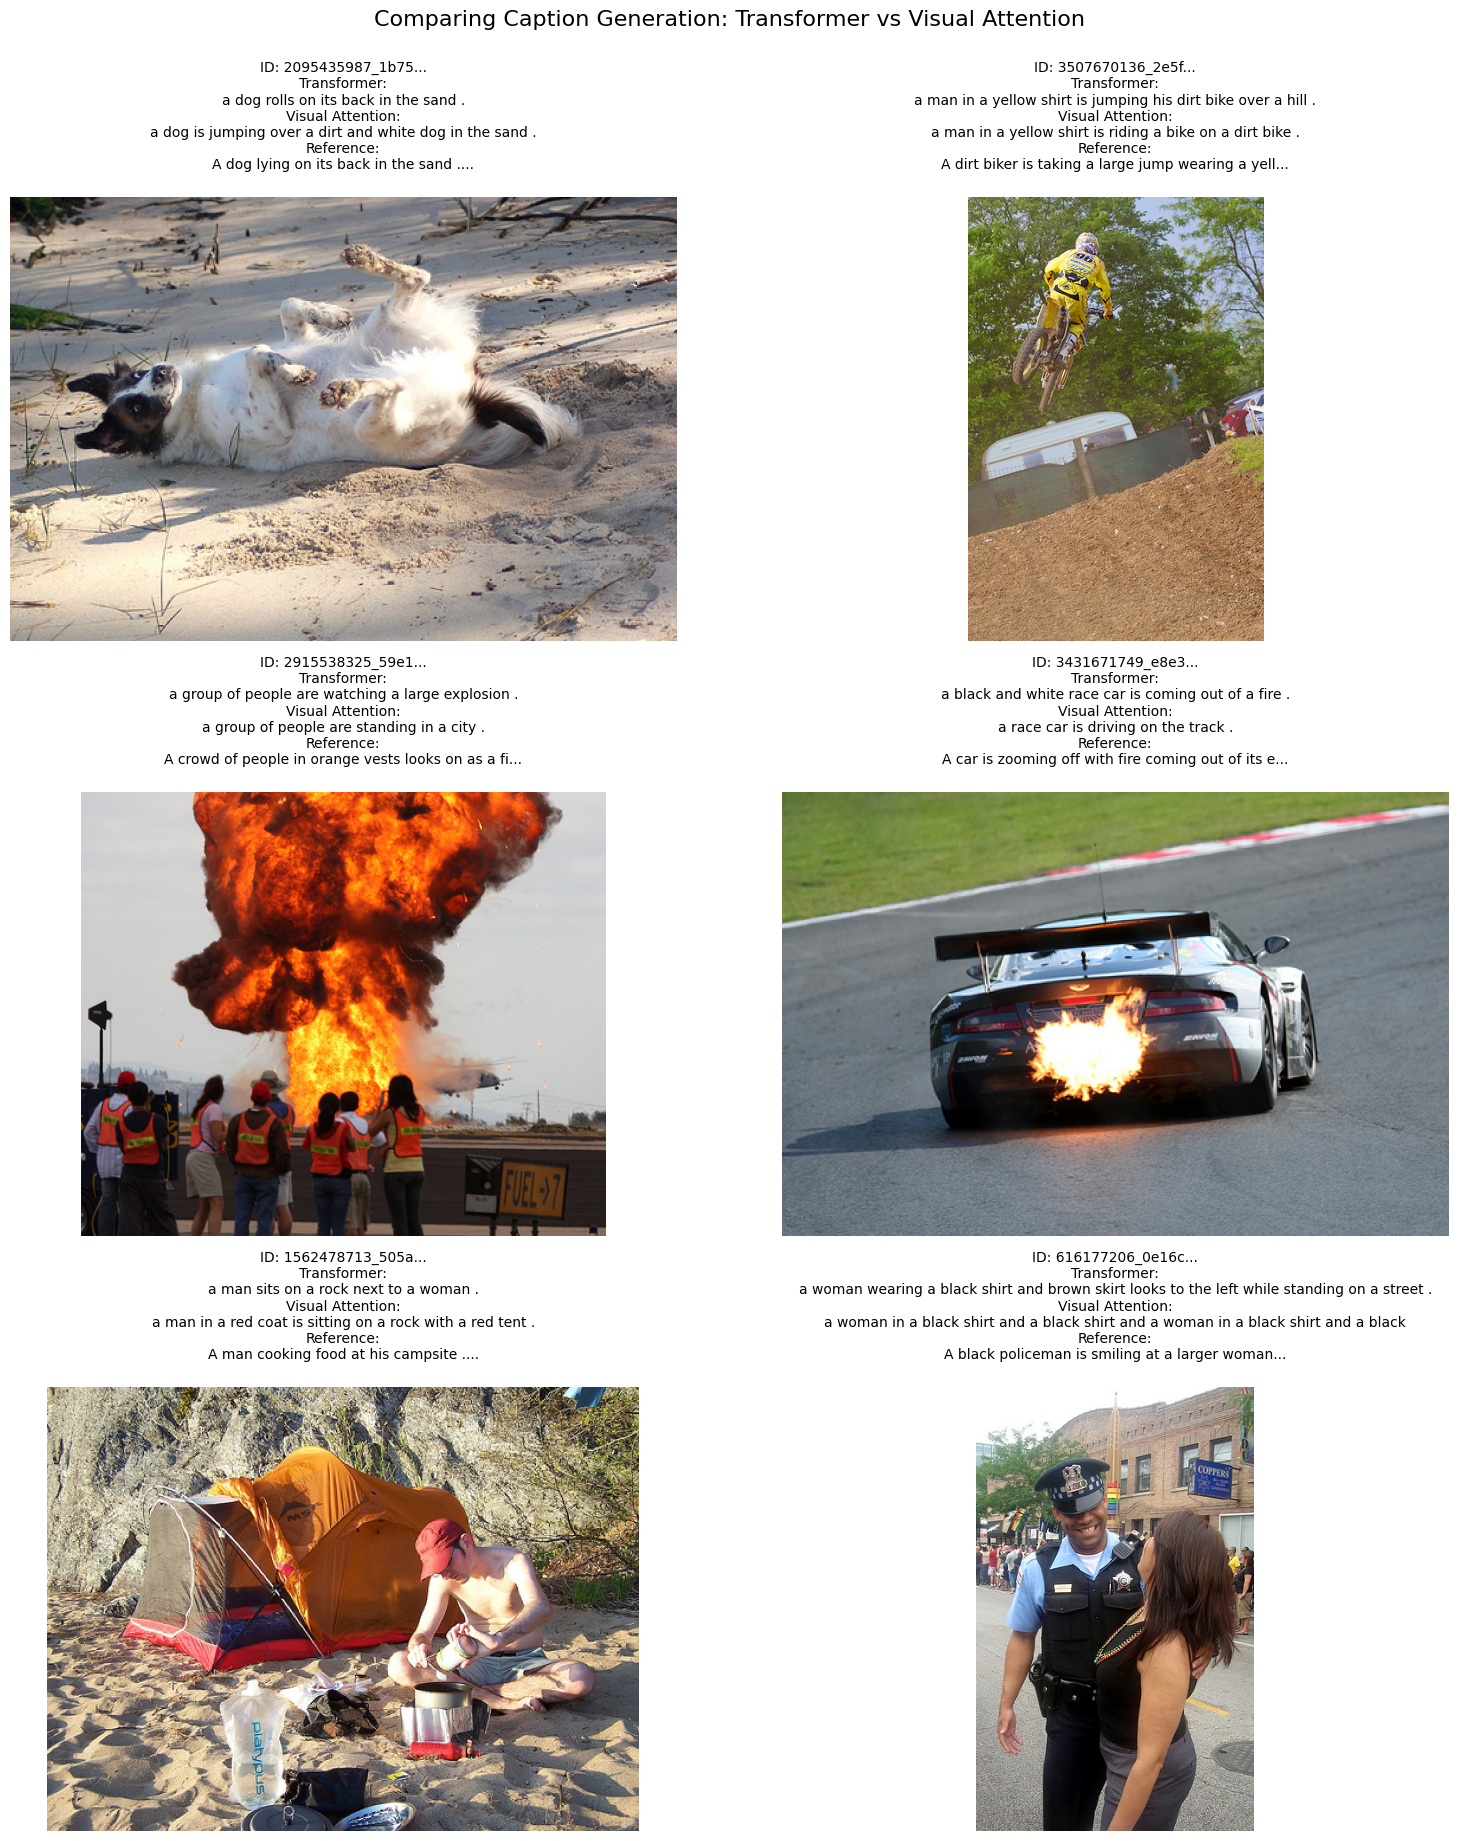


2. Detailed analysis for one image...


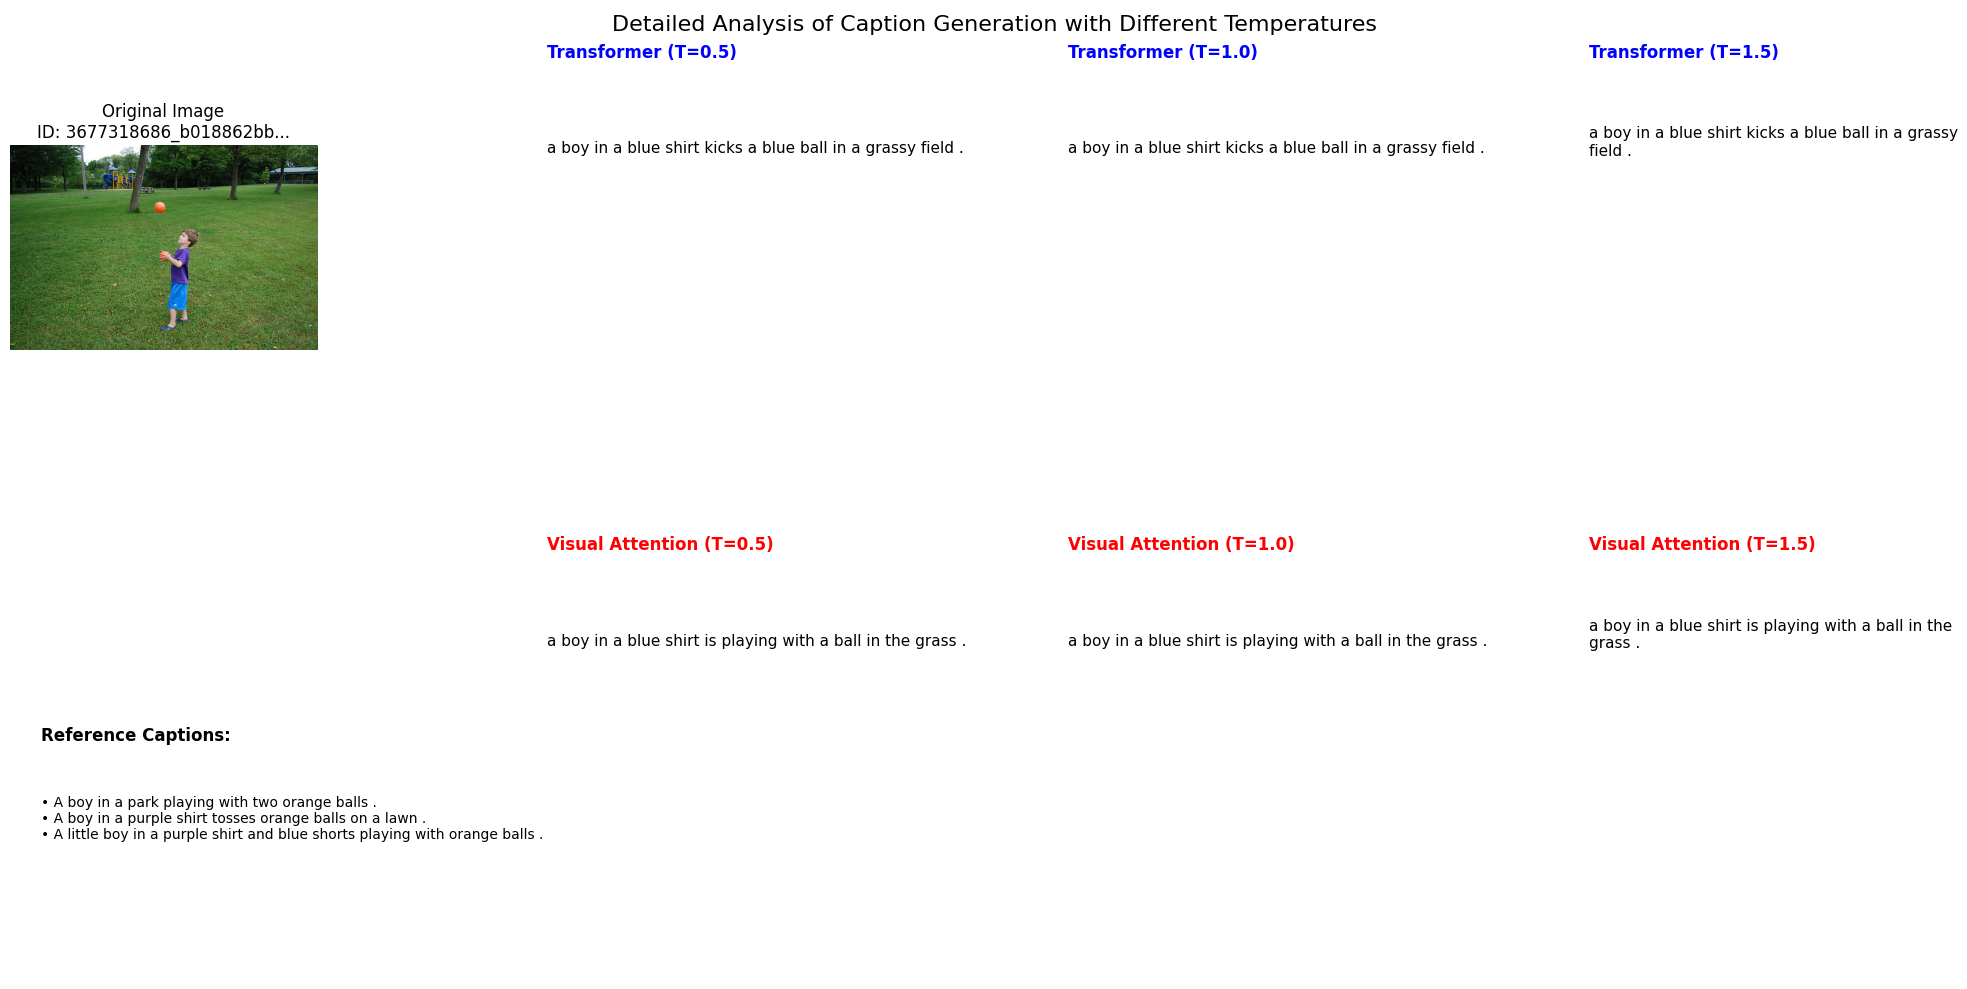


3. Batch Evaluation of Caption Quality...
Starting batch caption evaluation...


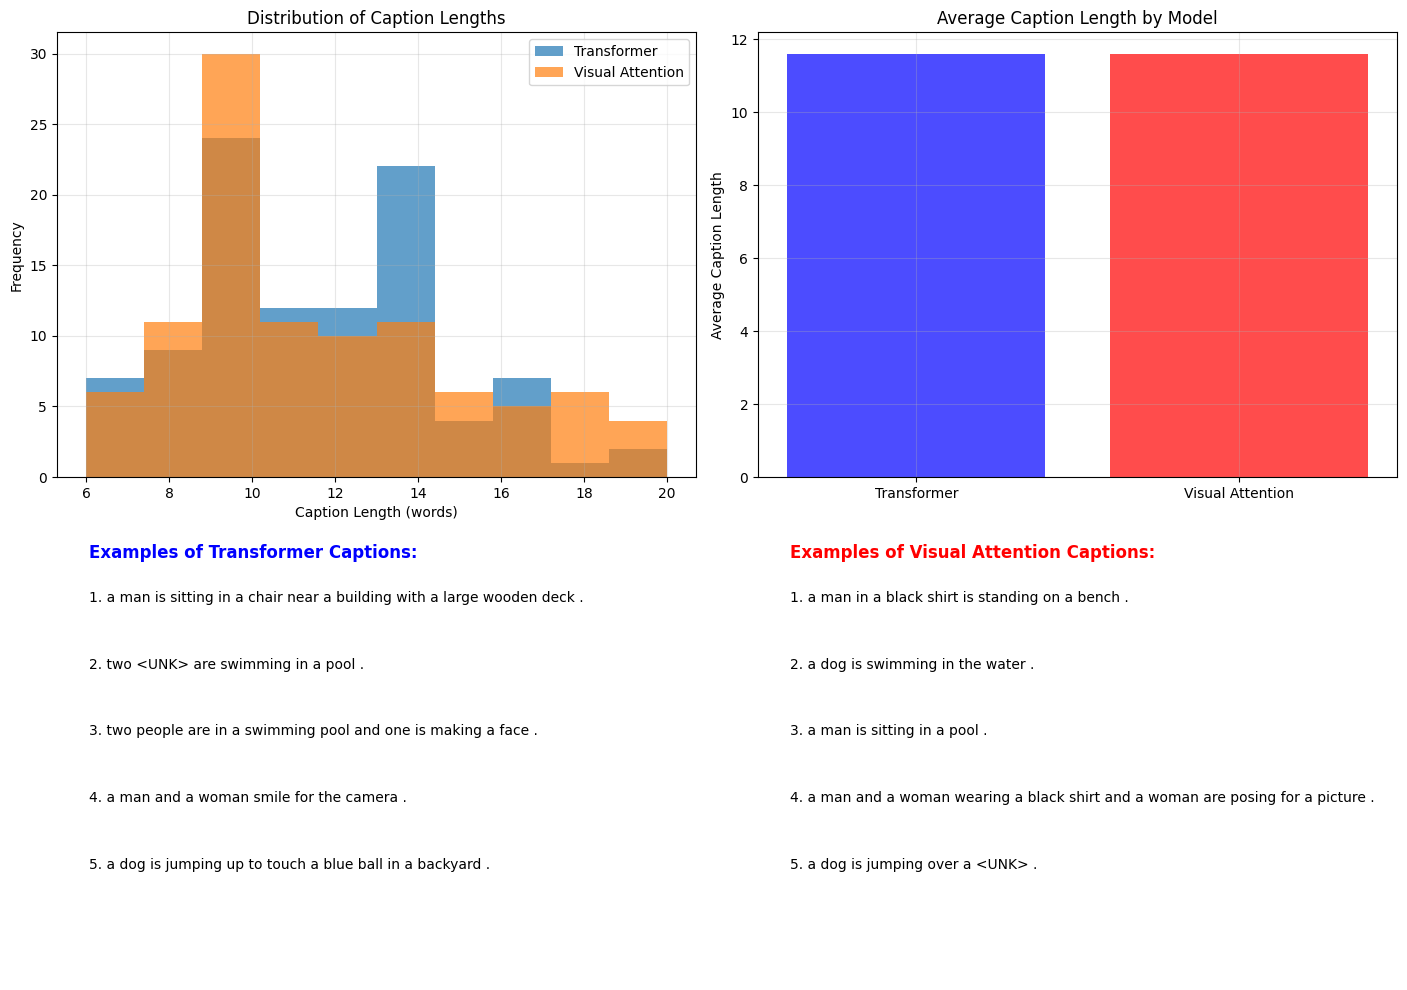


DEMO COMPLETED


In [13]:
def load_models_and_data():
    with open('vocab_pytorch.pkl', 'rb') as f:
        vocab = pickle.load(f)
    with open('image_features_pytorch.pkl', 'rb') as f:
        image_features = pickle.load(f)
    transformer_model = AttentionImageCaptionModel(
        feature_dim=2048, d_model=512, num_heads=8, num_layers=6,
        vocab_size=len(vocab), d_ff=2048, dropout=0.1
    )
    visual_attention_model = VisualAttentionModel(
        feature_dim=2048, embed_dim=256, hidden_dim=512,
        vocab_size=len(vocab), attention_dim=512, dropout=0.5
    )
    try:
        transformer_model.load_state_dict(torch.load('transformer_caption_model.pth', map_location=device))
        visual_attention_model.load_state_dict(torch.load('attention_caption_model.pth', map_location=device))
        print("Models successfully loaded!")
    except FileNotFoundError:
        print("Model files not found. Ensure models are trained and saved.")
        return None, None, None, None
    transformer_model.to(device)
    visual_attention_model.to(device)
    return transformer_model, visual_attention_model, vocab, image_features

def generate_captions_comparison(image_id, transformer_model, attention_model,
                               image_features, vocab, reference_captions=None,
                               temperature=1.0, max_length=20):
    if image_id not in image_features:
        print(f"Image {image_id} not found in features")
        return None
    features = torch.FloatTensor(image_features[image_id]).unsqueeze(0).to(device)
    transformer_caption = transformer_model.generate_caption(
        features, vocab, max_length=max_length, temperature=temperature
    )
    attention_caption = attention_model.generate_caption(
        features, vocab, max_length=max_length, temperature=temperature
    )
    return {
        'image_id': image_id,
        'transformer_caption': transformer_caption,
        'attention_caption': attention_caption,
        'reference_captions': reference_captions
    }

def visualize_caption_samples(models_data, image_features, vocab,
                            captions_dict=None, num_samples=6,
                            images_dir=r"C:\Users\g0d2o\OneDrive\Рабочий стол\final\images"):
    transformer_model, attention_model = models_data
    available_ids = list(image_features.keys())
    sample_ids = random.sample(available_ids, min(num_samples, len(available_ids)))
    rows = (num_samples + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(16, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    for idx, image_id in enumerate(sample_ids):
        row = idx // 2
        col = idx % 2
        image_path = os.path.join(images_dir, image_id)
        try:
            if os.path.exists(image_path):
                image = Image.open(image_path).convert('RGB')
            else:
                image = Image.new('RGB', (224, 224), color='lightgray')
        except:
            image = Image.new('RGB', (224, 224), color='lightgray')
        ref_captions = captions_dict.get(image_id, []) if captions_dict else []
        results = generate_captions_comparison(
            image_id, transformer_model, attention_model,
            image_features, vocab, ref_captions
        )
        if results:
            axes[row, col].imshow(image)
            axes[row, col].axis('off')
            caption_text = f"ID: {image_id[:15]}..."
            caption_text += f"\nTransformer:\n{results['transformer_caption']}"
            caption_text += f"\nVisual Attention:\n{results['attention_caption']}"
            if ref_captions:
                caption_text += f"\nReference:\n{ref_captions[0][:50]}..."
            axes[row, col].set_title(caption_text, fontsize=10, pad=20)
    for idx in range(num_samples, rows * 2):
        row = idx // 2
        col = idx % 2
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.suptitle('Comparing Caption Generation: Transformer vs Visual Attention',
                 fontsize=16, y=1.02)
    plt.show()

def detailed_caption_analysis(image_id, transformer_model, attention_model,
                            image_features, vocab, captions_dict=None,
                            temperatures=[0.5, 1.0, 1.5],
                            images_dir=r"C:\Users\g0d2o\OneDrive\Рабочий стол\final\images"):
    image_path = os.path.join(images_dir, image_id)
    try:
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('RGB')
        else:
            image = Image.new('RGB', (224, 224), color='lightgray')
    except:
        image = Image.new('RGB', (224, 224), color='lightgray')
    fig, axes = plt.subplots(2, len(temperatures) + 1, figsize=(20, 10))
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f'Original Image\nID: {image_id[:20]}...', fontsize=12)
    axes[0, 0].axis('off')
    axes[1, 0].text(0.1, 0.5, 'Reference Captions:', fontsize=12, weight='bold')
    if captions_dict and image_id in captions_dict:
        ref_text = '\n'.join([f"• {cap}" for cap in captions_dict[image_id][:3]])
        axes[1, 0].text(0.1, 0.3, ref_text, fontsize=10, wrap=True)
    else:
        axes[1, 0].text(0.1, 0.3, 'Not Found', fontsize=10)
    axes[1, 0].axis('off')
    for temp_idx, temperature in enumerate(temperatures):
        col = temp_idx + 1
        results = generate_captions_comparison(
            image_id, transformer_model, attention_model,
            image_features, vocab, temperature=temperature
        )
        if results:
            axes[0, col].text(0.05, 0.9, f'Transformer (T={temperature})',
                            fontsize=12, weight='bold', color='blue')
            axes[0, col].text(0.05, 0.7, results['transformer_caption'],
                            fontsize=11, wrap=True)
            axes[0, col].axis('off')
            axes[1, col].text(0.05, 0.9, f'Visual Attention (T={temperature})',
                            fontsize=12, weight='bold', color='red')
            axes[1, col].text(0.05, 0.7, results['attention_caption'],
                            fontsize=11, wrap=True)
            axes[1, col].axis('off')
    plt.tight_layout()
    plt.suptitle('Detailed Analysis of Caption Generation with Different Temperatures',
                 fontsize=16, y=0.98)
    plt.show()

def batch_caption_evaluation(transformer_model, attention_model, image_features,
                           vocab, captions_dict=None, num_samples=50):
    print("Starting batch caption evaluation...")
    sample_ids = random.sample(list(image_features.keys()),
                              min(num_samples, len(image_features)))
    results = {
        'transformer_captions': [],
        'attention_captions': [],
        'reference_captions': [],
        'image_ids': []
    }
    for image_id in sample_ids:
        caption_results = generate_captions_comparison(
            image_id, transformer_model, attention_model,
            image_features, vocab
        )
        if caption_results:
            results['transformer_captions'].append(caption_results['transformer_caption'])
            results['attention_captions'].append(caption_results['attention_caption'])
            results['image_ids'].append(image_id)
            if captions_dict and image_id in captions_dict:
                results['reference_captions'].append(captions_dict[image_id])
            else:
                results['reference_captions'].append(['No reference available'])
    transformer_lengths = [len(cap.split()) for cap in results['transformer_captions']]
    attention_lengths = [len(cap.split()) for cap in results['attention_captions']]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0, 0].hist(transformer_lengths, alpha=0.7, label='Transformer', bins=10)
    axes[0, 0].hist(attention_lengths, alpha=0.7, label='Visual Attention', bins=10)
    axes[0, 0].set_xlabel('Caption Length (words)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Caption Lengths')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    mean_lengths = [np.mean(transformer_lengths), np.mean(attention_lengths)]
    model_names = ['Transformer', 'Visual Attention']
    axes[0, 1].bar(model_names, mean_lengths, color=['blue', 'red'], alpha=0.7)
    axes[0, 1].set_ylabel('Average Caption Length')
    axes[0, 1].set_title('Average Caption Length by Model')
    axes[0, 1].grid(True, alpha=0.3)
    axes[1, 0].text(0.05, 0.95, 'Examples of Transformer Captions:',
                   fontsize=12, weight='bold', color='blue')
    for i, cap in enumerate(results['transformer_captions'][:5]):
        axes[1, 0].text(0.05, 0.85 - i*0.15, f"{i+1}. {cap}", fontsize=10)
    axes[1, 0].axis('off')
    axes[1, 1].text(0.05, 0.95, 'Examples of Visual Attention Captions:',
                   fontsize=12, weight='bold', color='red')
    for i, cap in enumerate(results['attention_captions'][:5]):
        axes[1, 1].text(0.05, 0.85 - i*0.15, f"{i+1}. {cap}", fontsize=10)
    axes[1, 1].axis('off')
    plt.tight_layout()
    plt.show()
    return results

def run_caption_demo():
    print("=" * 60)
    print("IMAGE CAPTIONING DEMO")
    print("=" * 60)
    models_and_data = load_models_and_data()
    if any(x is None for x in models_and_data):
        print("Error loading data. Ending execution.")
        return
    transformer_model, attention_model, vocab, image_features = models_and_data
    try:
        captions_path = r"C:\Users\g0d2o\OneDrive\Рабочий стол\final\captions.txt"
        with open(captions_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        captions_dict = {}
        for line in lines:
            if ',' in line:
                img_id, caption = line.strip().split(',', 1)
                if img_id not in captions_dict:
                    captions_dict[img_id] = []
                captions_dict[img_id].append(caption)
    except:
        print("Failed to load reference captions")
        captions_dict = None
    print(f"Loaded {len(image_features)} images")
    print(f"Vocabulary size: {len(vocab)} words")
    print("\n1. Generating captions for random images...")
    visualize_caption_samples(
        (transformer_model, attention_model),
        image_features, vocab, captions_dict, num_samples=6
    )
    print("\n2. Detailed analysis for one image...")
    sample_id = random.choice(list(image_features.keys()))
    detailed_caption_analysis(
        sample_id, transformer_model, attention_model,
        image_features, vocab, captions_dict
    )
    print("\n3. Batch Evaluation of Caption Quality...")
    batch_results = batch_caption_evaluation(
        transformer_model, attention_model,
        image_features, vocab, captions_dict, num_samples=100
    )
    print("\n" + "=" * 60)
    print("DEMO COMPLETED")
    print("=" * 60)
    return {
        'models': (transformer_model, attention_model),
        'vocab': vocab,
        'image_features': image_features,
        'batch_results': batch_results
    }

if __name__ == "__main__":
    demo_results = run_caption_demo()